In [1]:
from calibrate import Calibrate

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
%matplotlib inline



In [2]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
output_images = "output_images/"
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

calibrate = Calibrate(images, nx, ny)
print("Calibration Complete")

Calibration Complete


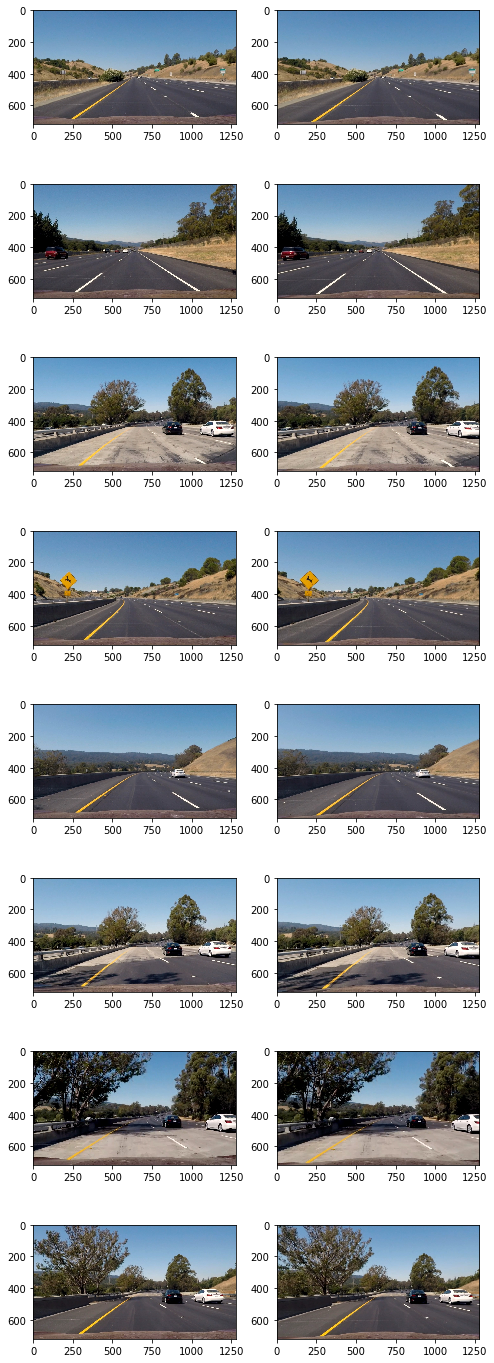

In [4]:
images = glob.glob('./test_images/*.jpg')
undistorted_images = "undistorted_images"
if not os.path.exists(output_images+undistorted_images):
    os.makedirs(output_images+undistorted_images)
undistorted_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(rows):
    img = mpimage.imread(images[i])
    undistorted_img = calibrate.undistort(img)
    output_fname = output_images+undistorted_images+images[i].split("\\")[-1]
    cv2.imwrite(output_fname, cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2BGR))
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(img)
    fig.add_subplot(rows, 2, i*2+2)
    plt.imshow(undistorted_img)
plt.show()

In [52]:
import thresholdutil as tu
def threshold_pipeline(img):
    mag_binary = tu.mag_thresh(img, mag_thresh=(70, 255))
    dir_binary = tu.dir_threshold(img, sobel_kernel=5, thresh=(0.7, 1.3))
    sx_binary = tu.abs_sobel_thresh(img, sobel_kernel=15, thresh=(70, 255))
    
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_binary = tu.binary_threshold(hls_img[:,:,2], thresh=(200,255))
    
    res_bin = np.zeros_like(dir_binary)
    res_bin[(dir_binary==1) & (mag_binary==1)] = 1
    res_bin[(hls_binary==1) | (sx_binary==1)] = 1
    
    return res_bin

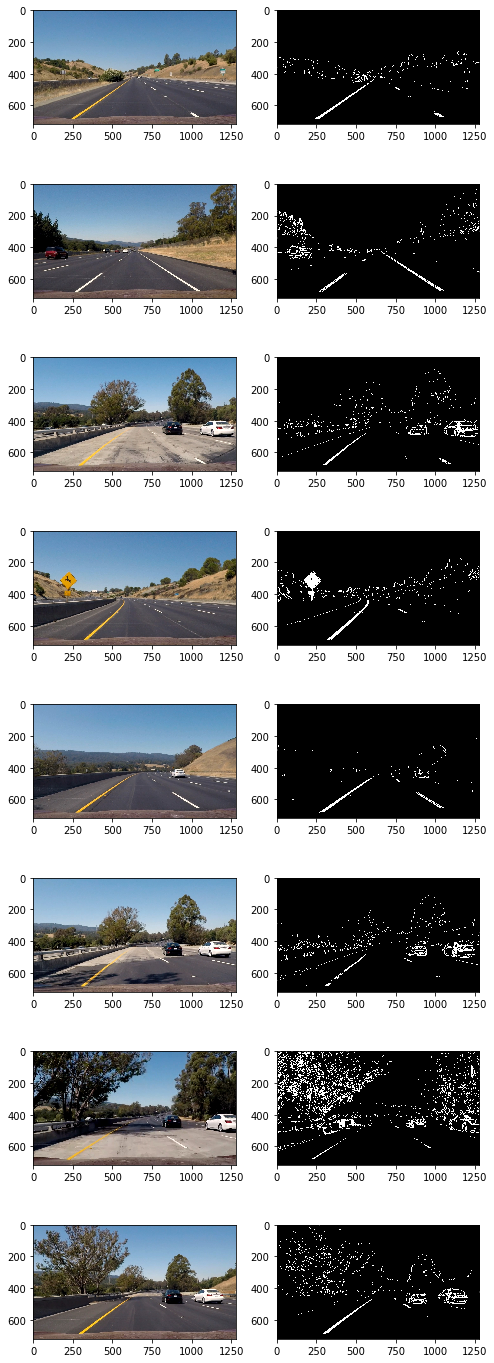

In [53]:

images = glob.glob('./test_images/*.jpg')
thresholded_images = "thresholded_images"
if not os.path.exists(output_images+thresholded_images):
    os.makedirs(output_images+thresholded_images)
thresholded_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(rows):
    img = mpimage.imread(images[i])
    output_fname = output_images+thresholded_images+images[i].split("\\")[-1]
    
    res_bin = threshold_pipeline(img)
    output_img = np.dstack((res_bin, res_bin, res_bin))*255
    
    cv2.imwrite(output_fname, output_img)
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(img)
    fig.add_subplot(rows, 2, i*2+2)
    plt.imshow(output_img)
plt.show()

In [54]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [63]:
from perspectivetransform import PerspectiveTransform
xy_bl = (230, 693)
xy_tl = (591, 450)
xy_tr = (689, 450)
xy_br = (1076, 693)
src_pts = [xy_bl, xy_tl, xy_tr, xy_br]

xy_bl = (300, 719)
xy_tl = (300, 0)
xy_tr = (980, 0)
xy_br = (980, 719)
dst_pts = [xy_bl, xy_tl, xy_tr, xy_br]
pt = PerspectiveTransform(src_pts, dst_pts)

xy_bl = (150, 720)
xy_tl = (451, 450)
xy_tr = (839, 450)
xy_br = (1130, 720)
roi_pts = np.array([[xy_bl, xy_tl, xy_tr, xy_br]])


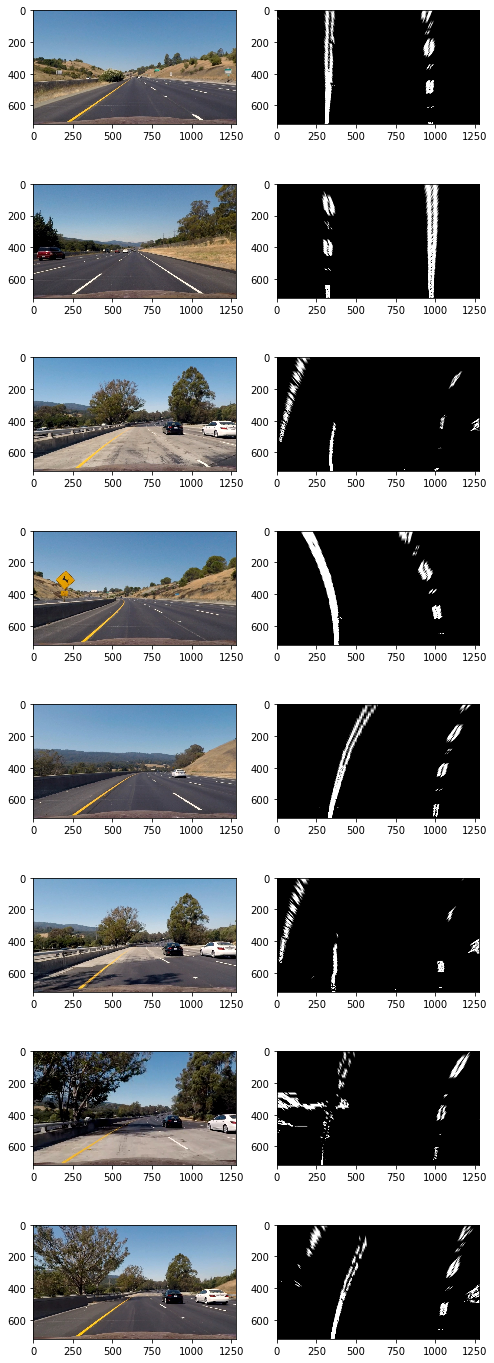

In [62]:

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
perspective_images = "perspective_images"
if not os.path.exists(output_images+perspective_images):
    os.makedirs(output_images+perspective_images)
perspective_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(rows):
    img = mpimage.imread(images[i])
    output_fname = output_images+perspective_images+images[i].split("\\")[-1]
    output_undist_fname = output_images+perspective_images+"undist_"+images[i].split("\\")[-1]
    
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    output_undistorted_img = pt.transform(undistorted_img)
    output_img = pt.transform(roi_img) 
    cv2.imwrite(output_undist_fname, cv2.cvtColor(output_undistorted_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    cv2.polylines(img,np.array([src_pts]),True,(0,255,0),thickness=5)
    cv2.polylines(img,np.array([dst_pts]),True,(0,0,255),thickness=5)
    cv2.polylines(img,roi_pts,True,(255,0,255),thickness=5)
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(undistorted_img)
    fig.add_subplot(rows, 2, i*2+2)
    plt.imshow(output_img)
    
    

plt.show()